In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
import matplotlib.dates as mdates
from datetime import date
#import polars as pl

In [2]:
df = pd.read_csv('pharmacy_tx.csv')

In [3]:
drugsplit=df['drug'].str.split(" ",n=1,expand=True)


In [4]:
df['drug_type']=drugsplit[0]
df['drug_name']=drugsplit[1]
df

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,drug_type,drug_name
0,2022-01-02,Pharmacy #6,G99.93,branded tanoclolol,725700,1UQC,NaN,False,13.39,branded,tanoclolol
1,2022-01-02,Pharmacy #42,U60.52,branded oxasoted,664344,NaN,52H8KH0F83K,False,7.02,branded,oxasoted
2,2022-01-02,Pharmacy #37,Q85.91,branded cupitelol,725700,1UQC,NaN,False,13.39,branded,cupitelol
3,2022-01-02,Pharmacy #30,U60.52,generic oxasoted,571569,KB38N,6BYJBW,False,10.84,generic,oxasoted
4,2022-01-02,Pharmacy #18,N55.01,branded mamate,664344,NaN,ZX2QUWR,False,47.00,branded,mamate
...,...,...,...,...,...,...,...,...,...,...,...
13910239,2022-12-30,Pharmacy #42,U27.71,branded colifunene,322463,NaN,HO8HUGL,True,0.00,branded,colifunene
13910240,2022-12-30,Pharmacy #45,N59.44,generic tafistitrisin,664344,NaN,TFZOR5R49,False,6.28,generic,tafistitrisin
13910241,2022-12-30,Pharmacy #54,W50.87,generic tanoclolol,691847,N098KI,6SP1DG,False,6.94,generic,tanoclolol
13910242,2022-12-30,Pharmacy #0,I68.27,branded prazinib,96934,S76J7V6,NaN,False,13.93,branded,prazinib


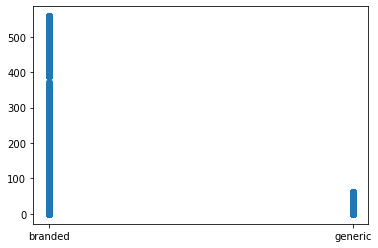

In [5]:
fig=plt.figure()

plt.scatter(df.drug_type,df.patient_pay)
plt.show()

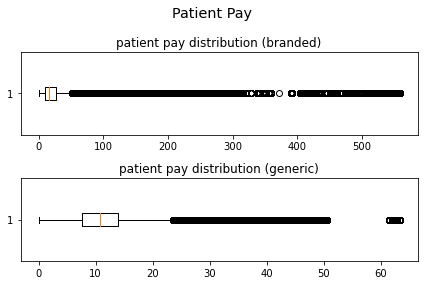

In [6]:

fig=plt.figure()
st=fig.suptitle("Patient Pay", fontsize="x-large")
# branded patient pay distribution
ax1=fig.add_subplot(211)
ax1.boxplot(df[df['drug_type']=='branded'].patient_pay,vert =0)
ax1.set_title("patient pay distribution (branded)")
#plt.subplot(211)

#plt.
ax2=fig.add_subplot(212)
#plt.suptitle("patient pay distribution (branded)")
#plt.subplot(212)
ax2.boxplot(df[df['drug_type']!='branded'].patient_pay,vert =0)

ax2.set_title("patient pay distribution (generic)")
fig.tight_layout()

plt.show()

Text(0, 0.5, 'Frequency')

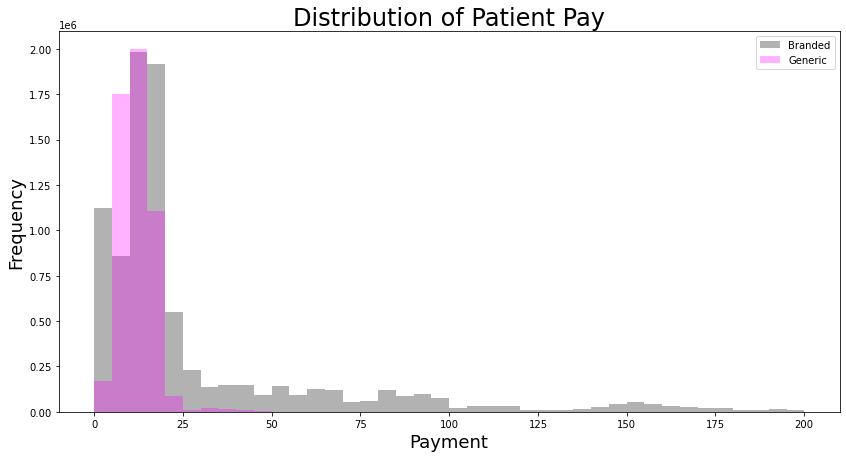

In [7]:
df[df['drug_type']=='branded'].patient_pay.plot(kind='hist',color='black',range=[0,200],alpha=0.3,figsize=(14,7),bins=40)
df[df['drug_type']=='generic'].patient_pay.plot(kind='hist',color='magenta',range=[0,200],alpha=0.3,figsize=(14,7),bins=40)
plt.legend(labels=['Branded', 'Generic'])
plt.title('Distribution of Patient Pay', size=24)
plt.xlabel('Payment', size=18)
plt.ylabel('Frequency', size=18)

From the graph above, generic drug is generally cheaper. The low-end (low price) distribution is pretty close to branded drug. But generic drug doesn't occur in the high-end (high price) frequently.

In [6]:
phar_dummy=pd.get_dummies(df.pharmacy) # 58 dummies
brand_dummy=1*(df.drug_type=='branded') 
diagnosis_dummy=pd.get_dummies(df.diagnosis) #133 dummies
brand_dummy=pd.DataFrame(data=brand_dummy)
bin_dummy=pd.get_dummies(df.bin) #12 dummies

rejected_dummy=pd.get_dummies(df.rejected) #2

In [12]:
#Single variable regression with branded/generic
Y=df.patient_pay

X=brand_dummy
X=sm.add_constant(X)
mod = sm.OLS(Y,X)
est = mod.fit()

print(est.summary())


                            OLS Regression Results                            
Dep. Variable:            patient_pay   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                 8.897e+05
Date:                Tue, 24 May 2022   Prob (F-statistic):               0.00
Time:                        15:13:28   Log-Likelihood:            -7.0454e+07
No. Observations:            13910244   AIC:                         1.409e+08
Df Residuals:                13910242   BIC:                         1.409e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4629      0.017    680.292      0.0

This result in some sense confirm that drug price differ a lot in branded/generic with a significant difference of $20

In [10]:
X=pd.concat([brand_dummy,bin_dummy.iloc[:,0:-1]],axis=1)
X.head()


,drug_type,96934,160389,322463,539437,571569,664344,691847,718350,725700,756120,757349
0,1,0,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,0,0


In [11]:
#Multivariable regression with branded/generic adding insurnace plan
Y=df.patient_pay
X=sm.add_constant(X)
mod = sm.OLS(Y,X)
est = mod.fit()

print(est.summary())

                            OLS Regression Results                            
Dep. Variable:            patient_pay   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                 8.676e+04
Date:                Thu, 19 May 2022   Prob (F-statistic):               0.00
Time:                        20:38:55   Log-Likelihood:            -7.0383e+07
No. Observations:            13910244   AIC:                         1.408e+08
Df Residuals:                13910231   BIC:                         1.408e+08
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.5557      0.074    209.701      0.0

After adding insurance plan, price difference in branded/generic keeps at $20 significantly. The payment differs siginificantly in insurance plan. 

In [173]:
X=pd.concat([brand_dummy,bin_dummy.iloc[:,0:-1],phar_dummy.iloc[:,0:-1]],axis=1) 
X=sm.add_constant(X)
X.head()

,const,drug_type,96934,160389,322463,539437,571569,664344,691847,718350,...,Pharmacy #51,Pharmacy #52,Pharmacy #53,Pharmacy #54,Pharmacy #55,Pharmacy #56,Pharmacy #57,Pharmacy #6,Pharmacy #7,Pharmacy #8
0,1.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1.0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# python throwout memory error here. I am going to calculating it manually then 

Y=df.patient_pay
X=sm.add_constant(X)
mod = sm.OLS(Y,X)
est = mod.fit()

print(est.summary())

In [13]:
beta= np.linalg.inv(X.transpose().dot(X)).dot(X.transpose()).dot(Y)

In [14]:
print(beta)

[ 1.53801617e+01  2.00530443e+01 -2.90630542e+00 -1.58894794e+00
 -1.15460644e+01 -6.93777179e-01 -3.80440383e+00 -4.10197507e+00
 -3.50196323e+00 -4.86037432e-01 -3.56528637e-01  8.83443255e-01
 -1.94133328e-01 -4.61938523e-01  2.94634796e-01  1.31569150e-01
  1.12630562e-01 -2.68304069e-01  3.62771246e-01  2.61301045e-01
  1.19350431e-01  2.59868515e-01  4.83259427e-01 -7.80007064e-02
  2.40775956e-01  2.86003995e-03  5.21211135e-02  7.75654757e-01
  3.55444327e-01  9.74390230e-03  5.01028739e-01  2.47005408e-01
  6.64014307e-02  5.94176642e-01 -2.41783815e-02  2.49705441e-02
  3.37066172e-02  3.79985092e-01 -1.58586076e-01  4.59593015e-01
  1.93276957e-01  1.30704349e-01  5.01831438e-01  2.41447508e-01
  2.84480315e-01  1.81673371e-01 -9.34278484e-02 -1.51940430e-01
  3.85726273e-01  2.61331401e-01 -4.60640632e-01  1.50918049e-01
  4.19250379e-01  4.31513606e-01  1.98853472e-01  3.70870788e-01
  2.52177191e-01  6.95981276e-01 -5.87300144e-01  6.35605382e-02
  8.28851172e-02  3.10877

In [15]:
y_pred = X.dot(beta)
## calculate the mse
print("the estimation mse is", np.sum(np.power(Y-y_pred, 2))/len(y_pred))
sigma=(np.sum(np.power(Y-y_pred, 2))/len(y_pred))**(1/2)
print("the variance of the error is",sigma)

the estimation mse is 1453.3305049981834
the variance of the error is 38.1225721193912


In [16]:
## calculate t-statistic for each variable

se=sigma*(np.diag(np.linalg.inv(X.transpose().dot(X))))**(1/2)
t=beta/se

In [ ]:
#list([X.columns,t])

In [17]:
d={'varaible':X.columns,'coef':beta,'t':t}
test_result=pd.DataFrame(data=d)
print(test_result.to_markdown())

|    | varaible     |         coef |            t |
|---:|:-------------|-------------:|-------------:|
|  0 | const        |  15.3802     |  145.19      |
|  1 | drug_type    |  20.053      |  948.089     |
|  2 | 96934        |  -2.90631    |  -34.7278    |
|  3 | 160389       |  -1.58895    |  -15.2284    |
|  4 | 322463       | -11.5461     | -150.246     |
|  5 | 539437       |  -0.693777   |   -7.68546   |
|  6 | 571569       |  -3.8044     |  -44.7986    |
|  7 | 664344       |  -4.10198    |  -54.28      |
|  8 | 691847       |  -3.50196    |  -43.6545    |
|  9 | 718350       |  -0.486037   |   -4.63282   |
| 10 | 725700       |  -0.356529   |   -4.59236   |
| 11 | 756120       |   0.883443   |    7.55387   |
| 12 | 757349       |  -0.194133   |   -2.3455    |
| 13 | Pharmacy #0  |  -0.461939   |   -4.23231   |
| 14 | Pharmacy #1  |   0.294635   |    2.71059   |
| 15 | Pharmacy #10 |   0.131569   |    1.22049   |
| 16 | Pharmacy #11 |   0.112631   |    1.04108   |
| 17 | Pharm

According to the multivariable regression result with pharmacy, branded/generic, insurance plan as independent varaible, we can see insurance plan and generic/branded have very strong and siginificant effect on patient pay. Pharmacy location can explain some variation in the price, but may not be siginificant in some pharmacies. 

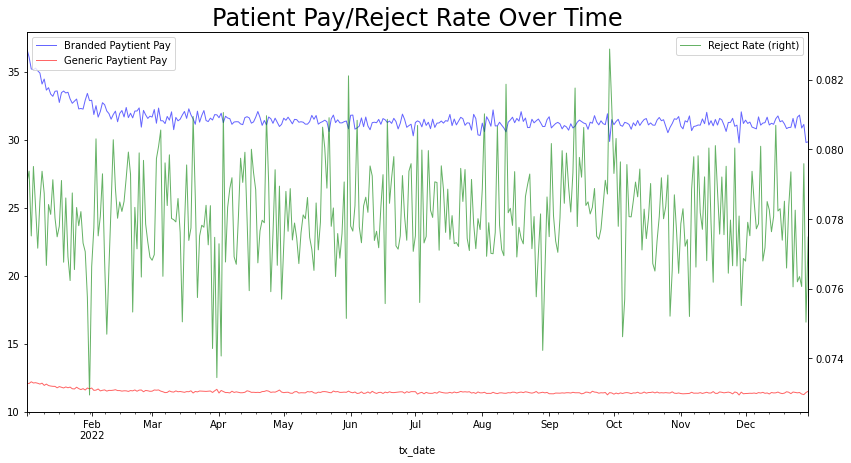

In [153]:
#Check price pattern over time
#date_time=pd.to_datetime(df['tx_date'])

#plt.scatter(pd.to_datetime(df['tx_date']),df['patient_pay'],alpha=0.3)
#plot the mean price over time


bpay=df[df['drug_type']=='branded']
gpay=df[df['drug_type']=='generic']
bpay=df[df['drug_type']=='branded'].groupby(['tx_date'])['patient_pay'].mean()
gpay=df[df['drug_type']=='generic'].groupby(['tx_date'])['patient_pay'].mean()
#breject=df[df['drug_type']=='branded'].groupby(['tx_date'])['rejected'].mean()
#greject=df[df['drug_type']=='generic'].groupby(['tx_date'])['rejected'].mean()
#these two are similar
reject=df.groupby(['tx_date'])['rejected'].mean()

bpay=pd.DataFrame(bpay)
bpay.columns=['Branded Paytient Pay']
bpay.index = pd.to_datetime(bpay.index)

gpay=pd.DataFrame(gpay)
gpay.index = pd.to_datetime(gpay.index)
gpay.columns=['Generic Paytient Pay']
#breject.index=pd.to_datetime(breject.index)
#greject.index=pd.to_datetime(breject.index)
reject.index=pd.to_datetime(breject.index)


ax1=bpay.plot(figsize=(14,7),color='blue',linewidth=1,alpha=0.6,label='Branded_Patient_Pay')
ax2=gpay.plot(color='red',linewidth=1,ax=ax1,alpha=0.6,label='Generic_Patient_Pay')
ax3=reject.plot(color='green',secondary_y=True,linewidth=1,alpha=0.6,label='Reject Rate')

months = mdates.MonthLocator(interval=1, bymonthday=-1)
months_fmt = mdates.DateFormatter('%y-%m-%d')
#plt.legend()
ax1.legend(loc=2)
ax3.legend(loc=1)
#plt.legend(labels=['Branded/Paytient Pay', 'Generic/Paytient Pay','Reject Rate'])

plt.title('Patient Pay/Reject Rate Over Time', size=24)
plt.xlabel('Date', size=18)
#plt.ylabel('Patient Pay', size=18)
#plt.gcf().autofmt_xdate()
plt.show()


Patient pay at the peak at January. It's relative stable throughout the year. 

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

In [161]:
tree1 = DecisionTreeClassifier(max_depth = 5)
Y_r=rejected_dummy.iloc[:,0:-1]

## Fit the modelsdf.rejected
tree1.fit(X, Y_r)



D:\Download\Anaconda_python\Conda2022\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


DecisionTreeClassifier(max_depth=5)

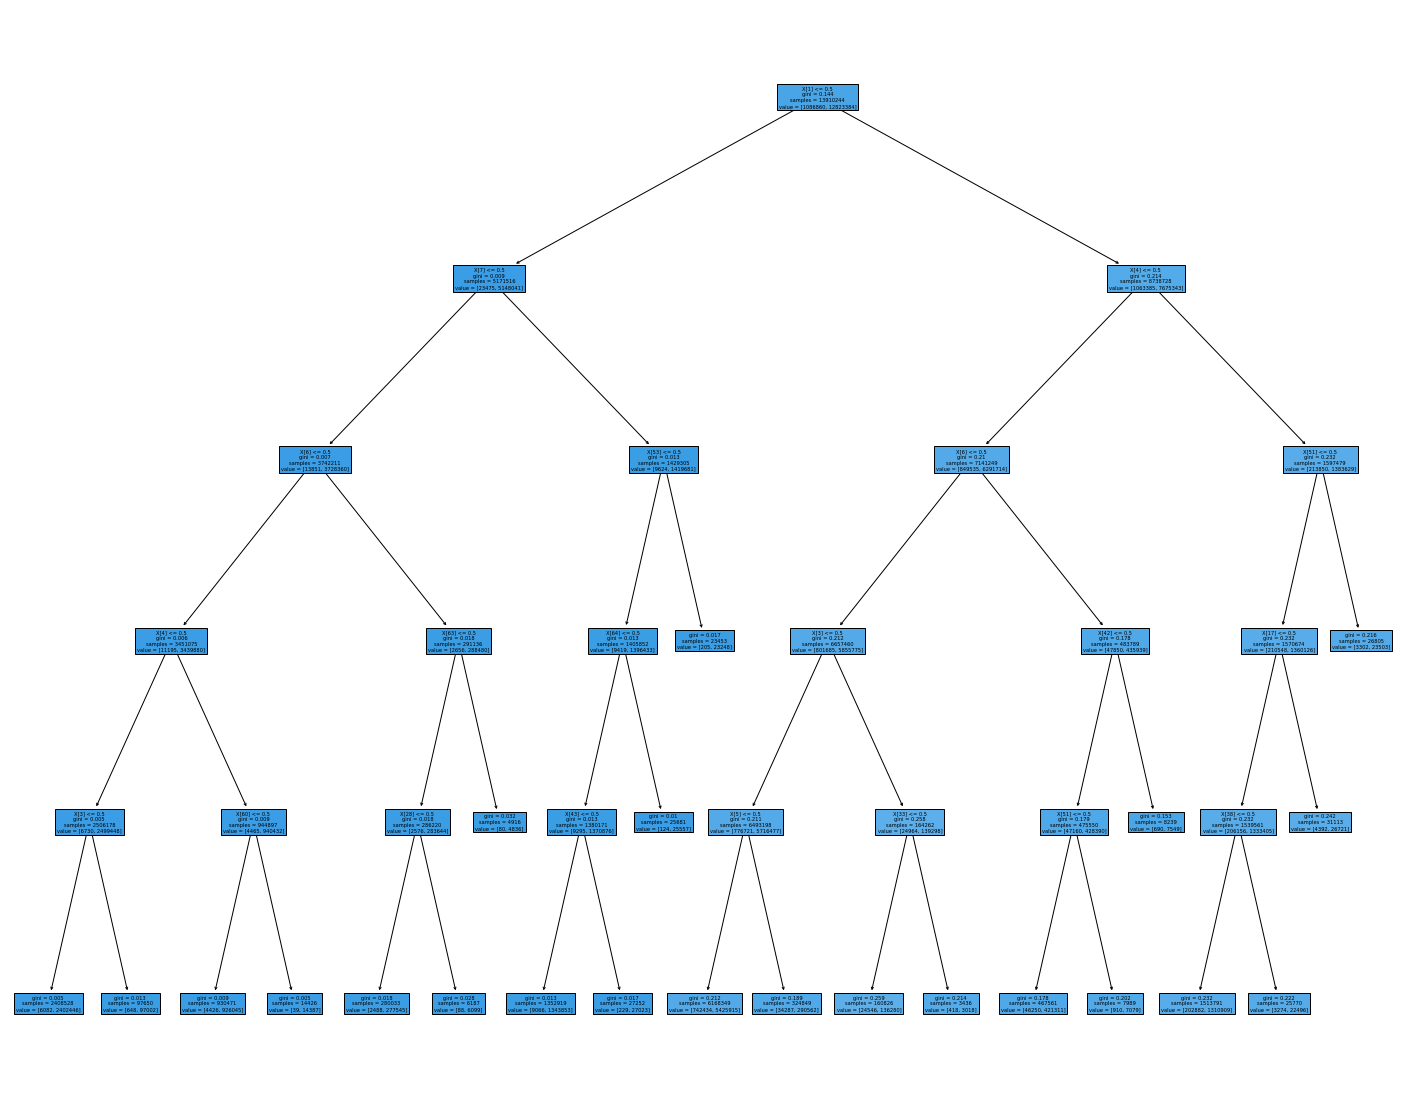

In [164]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(tree1, 
             
                   filled=True)
plt.show()

In [9]:
## Random Forest
rf = RandomForestClassifier( n_estimators=1000, 
                                max_depth = 4, 
                                random_state = 999,
                                max_samples = 100)

X=pd.concat([brand_dummy,bin_dummy.iloc[:,0:-1],phar_dummy.iloc[:,0:-1],diagnosis_dummy.iloc[:,0:-1]],axis=1) 
Y_r=rejected_dummy.iloc[:,0:-1]

In [10]:
rf.fit(X, Y_r)
#takes 22GB to run this random forest. I will add date as feature later. 

D:\Download\Anaconda_python\Conda2022\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\nzy12\AppData\Local\Temp\ipykernel_33260\451488431.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X, Y_r)


RandomForestClassifier(max_depth=4, max_samples=100, n_estimators=1000,
                       random_state=999)

In [11]:
#Feature Importances
rf.feature_importances_
score_df = pd.DataFrame({'feature':X.columns,
                            'importance_score': rf.feature_importances_})

score_df.sort_values('importance_score',ascending=False)
score_df.head(30)

,feature,importance_score
0,drug_type,0.055111
1,96934,0.014306
2,160389,0.008068
3,322463,0.028146
4,539437,0.013012
5,571569,0.010869
6,664344,0.030699
7,691847,0.016368
8,718350,0.007971
9,725700,0.022572


In [ ]:
#Feature Importances

X_train, X_test, y_train, y_test = train_test_split(X.copy(),Y_r.copy(),
                                                       shuffle=True,
                                                       random_state=111,
                                                       stratify=Y_r,
                                                       test_size=.2)


In [ ]:
forest = RandomForestClassifier(n_estimators=500, max_depth=4)

forest.fit(X_train, y_train)

forest.feature_importances_

score_df = pd.DataFrame({'feature':X_train.columns,
                            'importance_score': forest.feature_importances_})

score_df.sort_values('importance_score',ascending=False)